In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torchsummary import summary
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Device configuration for CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Function to load CIFAR-10 dataset
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = 'cifar-10-python/cifar-10-batches-py'

# Load metadata (labels)
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# Load training data for preprocessing
train_data = []
train_labels = []

for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

In [ ]:
# Data augmentation and normalization
'''
    Convert numpy array (in HWC format) to PIL Image required by torchvision transformers
    Randomly rotates the image by a degree in the range [-10, 10]
    Adjusts brightness, contrast, and saturation
    Randomly flips the image horizontally with a probability of 50%
    Randomly adjusts the sharpness of the image with a probability of 20%
    Randomly crops the image to a 32x32 size with a padding of 4 pixels around the image
    Converts the image to a PyTorch tensor (scaling pixel values to [0, 1])
    Normalizes the tensor using the mean and standard deviation for CIFAR-10
    Randomly erases a portion of the image with 20% probability to further augment data
'''
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2,scale=(0.02, 0.1),value=1.0, inplace=False)
])


# Convert to TensorDataset and apply transformations
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    """
    Parameters:
        images (numpy array): Array of images.
        labels (numpy array): Corresponding labels.
        transform (optional)
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

# Split into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Load test dataset
cifar_test_path = 'cifar-10-python/cifar-10-batches-py/test_batch'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0
test_labels = np.array(test_batch[b'labels'])

# Define transformation
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format

# Convert test dataset to Tensor
test_dataset = [(test_transform(img), label) for img, label in zip(test_images, test_labels)]

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Train function with Metric logging
def train_model(model, train_loader, val_loader, epochs=50):
    """
    Train the model and record metrics for each epoch for later plotting.

    Parameters:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        epochs: Number of training epochs.

    Returns:
        train_loss_history: List of average training losses per epoch.
        val_loss_history: List of average validation losses per epoch.
        train_acc_history: List of training accuracies per epoch.
        val_acc_history: List of validation accuracies per epoch.
        lr_history: List of learning rates used at each epoch.
    """
    # CrossEntropyLoss for classification
    criterion = nn.CrossEntropyLoss()
    # using AdamW instead of standard SGD for better convergence
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
    # Set up a learning rate scheduler (StepLR)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.85)  # Learning rate decay

    # Initialize lists to record metrics for plotting later
    train_loss_history = []   # Average training loss per epoch
    val_loss_history = []     # Average validation loss per epoch
    train_acc_history = []    # Training accuracy per epoch
    val_acc_history = []      # Validation accuracy per epoch
    lr_history = []           # Learning rate at each epoch

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0 # Accumulate loss over batches
        correct_train = 0 # Count correct predictions in training
        total_train = 0 # Total training samples

        #iterate over training batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) # Move data to device (GPU/CPU)
            optimizer.zero_grad() # clear previous gradients
            outputs = model(images) # forward pass: compute gradients
            loss = criterion(outputs, labels) # compute loss between outputs and true label
            loss.backward() # backward pass: compute gradients
            optimizer.step() # update model parameters
            running_loss += loss.item() # accumulate loss for this epoch

            # calculating the accuracy for the batch
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training metrics for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Evaluating model on validation DataLoader
        model.eval()
        running_val_loss = 0.0 # Accumulate validation loss
        correct_val = 0 # Count correct validation predictions
        total_val = 0 # Total validation samples

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and validation accuracy for the epoch
        avg_val_loss = running_val_loss/len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        # updating the learning rate using scheduler to ensure Normalized values received
        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    print("Training complete.")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lr_history

In [ ]:
# architecture of the model
class BasicBlock(nn.Module):
    """
    A Basic Residual Block that implements:
        ReLU(BN(conv(x)) + BN(conv(x)) + shortcut(x))
    This block consists of two 3x3 convolutional layers with batch normalization.
    If the input and output dimensions differ, a shortcut (projection) is applied using a 1x1 convolution.
    """
    def __init__(self, in_planes, planes, kernel, skip_kernel, stride=1, bias=True):
        super(BasicBlock, self).__init__()
        # First convolution layer with specified kernel size, stride, and padding
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=kernel[0], stride=stride, padding=kernel[1], bias=bias)
        # Batch normalization for the first conv layer output
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolution layer (stride fixed to 1) with same kernel size and padding
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=kernel[0],stride=1, padding=kernel[1], bias=bias)
        # Batch normalization for the second conv layer output
        self.bn2 = nn.BatchNorm2d(planes)

        # apply a 1x1 convolution followed by batch normalization
        self.shortcut = nn.Sequential()
        # The shortcut connection if the dimensions change - stride or channel error
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=skip_kernel[0], padding=skip_kernel[1], stride=stride, bias=bias),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        '''
        Forward pass for the BasicBlock.
        1. Apply conv1, BN, and ReLU activation.
        2. Apply conv2 and BN.
        3. Add the shortcut connection to the main branch output
        4. Apply final ReLU activation
        '''
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    '''
    A custom implementation of a Residual Network (ResNet) for CIFAR-10 classification.
    The network is built using a stack of residual layers where each layer is composed of multiple BasicBlocks

    Parameters:
        block: The block class to use (BasicBlock)
        in_planes: The number of channels in the first convolutional layer
        num_layers: The number of residual layers
        num_blocks: A list indicating how many BasicBlocks to include in each residual layer
        kernel: A tuple representing the kernel size and padding for standard convolutions
        skip_kernel: A tuple representing the kernel size and padding for the shortcut convolution
        num_classes: The number of output classes (default is 10 for CIFAR-10).
        bias: Whether to include a bias term in convolutions (default is True).
    '''
    def __init__(self, block, in_planes, num_layers, num_blocks, kernel, skip_kernel, num_classes=10, bias=True):
        # Ensure num_blocks is provided as a list with one entry per layer.
        if not isinstance(num_blocks, list):
            raise Exception("num_blocks parameter should be a list of integer values")
        if num_layers != len(num_blocks):
            raise Exception("Residual layers should be equal to the length of num_blocks list")
        super(ResNet, self).__init__()

        self.kernel = kernel
        self.skip_kernel = skip_kernel
        self.in_planes = in_planes

        # Conv -> BN
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=kernel[0],
                               stride=1, padding=kernel[1], bias=bias)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.num_layers = num_layers

        # Build the first residual layer (without spatial downsampling)
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1, bias=bias)
        # Build subsequent residual layers; spatial resolution is reduced by a factor of 2 per layer
        for i in range(2, num_layers+1):
            # Double the number of channels at each layer (except the first)
            setattr(self, "layer"+str(i), self._make_layer(block, 2*self.in_planes, num_blocks[i-1], stride=2, bias=bias))
        finalshape = list(getattr(self, "layer"+str(num_layers))[-1].modules())[-2].num_features
        self.multiplier = 4 if num_layers == 2 else (2 if num_layers == 3 else 1)
        # Adaptive average pooling to produce a fixed output size (1x1 feature map per channel)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.2)
        # Final fully connected (linear) layer for classification
        self.linear = nn.Linear(finalshape, num_classes)
        self.path = "./project1_model.pt"

    def _make_layer(self, block, planes, num_blocks, stride, bias=True):
        """
        Constructs a residual layer composed of multiple BasicBlocks.
        Each layer begins with a block that may perform downsampling (using stride > 1),
        followed by additional blocks that maintain the same spatial dimensions.
        """
        strides = [stride] + [1]*(num_blocks-1) # First block uses given stride; subsequent blocks use stride 1.
        custom_layers = []
        for stride in strides:
            custom_layers.append(block(self.in_planes, planes,self.kernel,self.skip_kernel, stride, bias))
            self.in_planes = planes # Update in_planes for subsequent blocks
        return nn.Sequential(*custom_layers)

    def forward(self, x):
        """
        Defines the forward pass for the ResNet model.
        1. Applies the initial convolution and batch normalization followed by ReLU.
        2. Passes the result through each residual layer.
        3. Applies adaptive average pooling to produce a fixed-size output.
        4. Flattens the output and applies dropout for regularization.
        5. Classifies the output using the final linear layer.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        # Iterate through each residual layer by dynamically accessing the layer attribute.
        for i in range(1, self.num_layers+1):
            out = eval("self.layer" + str(i) + "(out)")
        out = F.avg_pool2d(out, 4*self.multiplier)
        out = out.view(out.size(0), -1) # Flatten the tensor
        out = self.dropout(out) # Dropout for regularization
        out = self.linear(out) # Final classification
        return out

    def saveToDisk(self):
        torch.save(self.state_dict(), self.path)

    def loadFromDisk(self):
        self.load_state_dict(torch.load(self.path))

In [ ]:
# put models to devices (CPU/GPU)
model = ResNet(BasicBlock, 64, 3, [3, 4, 3], kernel=(3,1), skip_kernel=(1,0), num_classes=10, bias=True).to(device)

# Print the number of parameters
summary(model, (3, 32, 32))

# Train the model on 100 epochs
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lr_history = train_model(model, train_loader, val_loader, epochs=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 1.6557, Train Acc: 37.85%, Val Loss: 1.4060, Val Acc: 48.04%, LR: 0.001000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2, Loss: 1.2389, Train Acc: 54.96%, Val Loss: 1.2034, Val Acc: 57.42%, LR: 0.001000
Epoch 3, Loss: 1.0369, Train Acc: 62.81%, Val Loss: 1.0978, Val Acc: 61.68%, LR: 0.001000
Epoch 4, Loss: 0.9089, Train Acc: 67.85%, Val Loss: 1.0664, Val Acc: 63.56%, LR: 0.001000
Epoch 5, Loss: 0.8130, Train Acc: 71.51%, Val Loss: 0.8839, Val Acc: 69.56%, LR: 0.001000
Epoch 6, Loss: 0.7262, Train Acc: 74.70%, Val Loss: 0.9611, Val Acc: 69.06%, LR: 0.001000
Epoch 7, Loss: 0.6570, Train Acc: 77.17%, Val Loss: 0.8298, Val Acc: 72.34%, LR: 0.001000
Epoch 8, Loss: 0.6027, Train Acc: 79.05%, Val Loss: 0.6542, Val Acc: 77.28%, LR: 0.001000
Epoch 9, Loss: 0.5530, Train Acc: 81.03%, Val Loss: 0.6523, Val Acc: 77.72%, LR: 0.001000
Epoch 10, Loss: 0.5117, Train Acc: 82.22%, Val Loss: 0.5650, Val Acc: 81.06%, LR: 0.001000
Epoch 11, Loss: 0.4747, Train Acc: 83.51%, Val Loss: 0.5247, Val Acc: 81.56%, LR: 0.001000
Epoch 12, Loss: 0.4470, Train Acc: 84.55%, Val Loss: 0.5605, Val Acc: 81.44%, LR: 0.001000
Epoch 1

In [ ]:
# generate submission file and evaluate test accuracy
model.eval()
correct = 0
total = 0
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
torch.save(model.state_dict(), "resnet_model_4.6M.pt")

Test Accuracy: 92.07%


In [ ]:
cifar10_classes = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

Submission file saved.


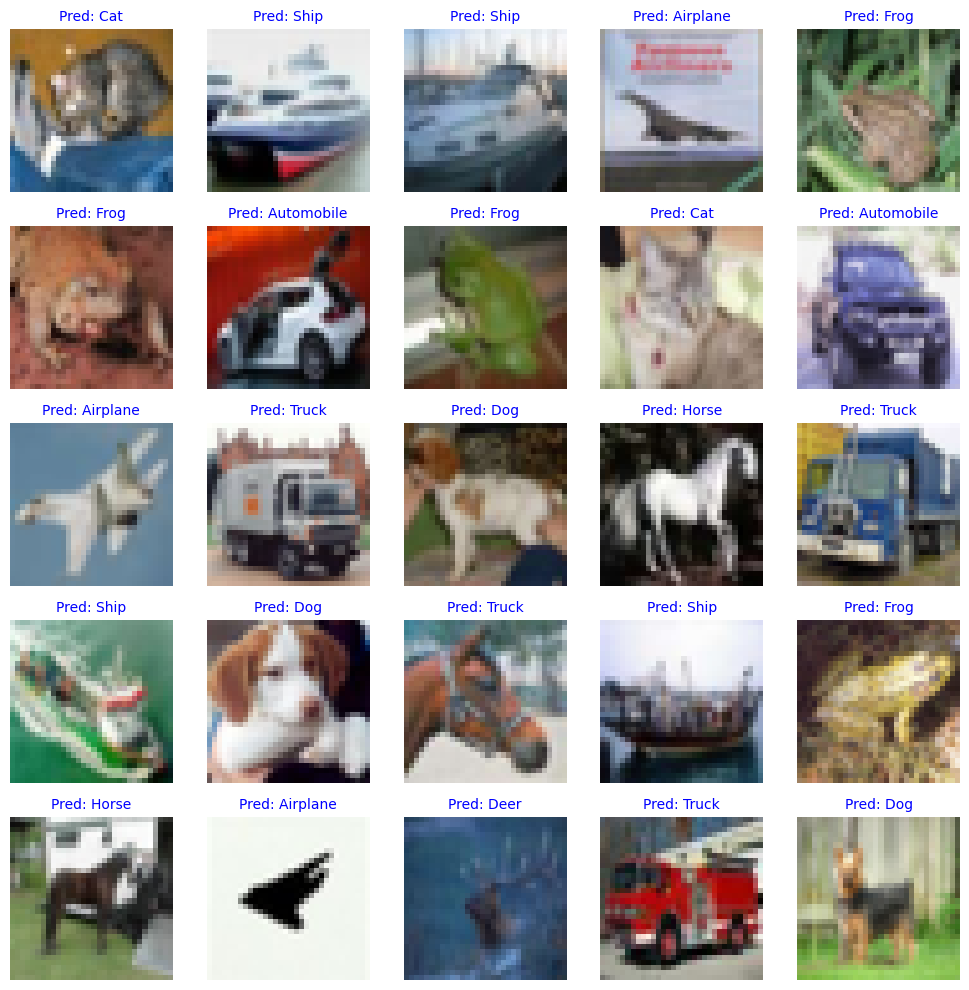

In [ ]:
# # Load your trained model
# model_path = "/content/resnet_model_new.pth"  # Change this to your model's actual path
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Assuming your model class is defined as "YourModelClass"
# model.load_state_dict(torch.load(model_path, map_location=device))  # Load the trained weights
model.to(device)
model.eval()  # Set to evaluation mode

# Load CIFAR test batch
cifar_test_path = 'cifar-10-python/cifar_test_nolabel.pkl'
submission_test_batch = load_cifar_batch(cifar_test_path)
# A numpy array of shape (num_images, height * width * channels)
submission_test_images = submission_test_batch[b'data'].astype(np.float32) / 255.0


# Define transformation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Convert test dataset to Tensor
# 1D to (3, 32, 32)
submission_test_dataset = [test_transform(img.reshape(3, 32, 32).transpose(1, 2, 0)) for img in submission_test_images]
submission_test_loader = DataLoader(submission_test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Initialize predictions
predictions = []

# Visualization setup
fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid
axes = axes.flatten()

# Run inference
with torch.no_grad():
    for i, images in enumerate(submission_test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

        # Visualize first 25 images
        if i == 0:
            for j in range(min(25, len(images))):  # Limit to 25 images
                img = submission_test_images[j].reshape(3, 32, 32).transpose(1, 2, 0)  # Get original image
                # convert flattened image (3072) back to (3, 32, 32) pt format
                # transpose converts (C,H,W) to (H,W,C)
                label = predicted[j].item()

                axes[j].imshow(img)
                axes[j].set_title(f"Pred: {cifar10_classes[label]}", fontsize=10, color="blue")
                axes[j].axis("off")

# Save predictions to CSV
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('submission_resnet_4M.csv', index=False)
print("Submission file saved.")

# Show visualization
plt.tight_layout()
plt.show()

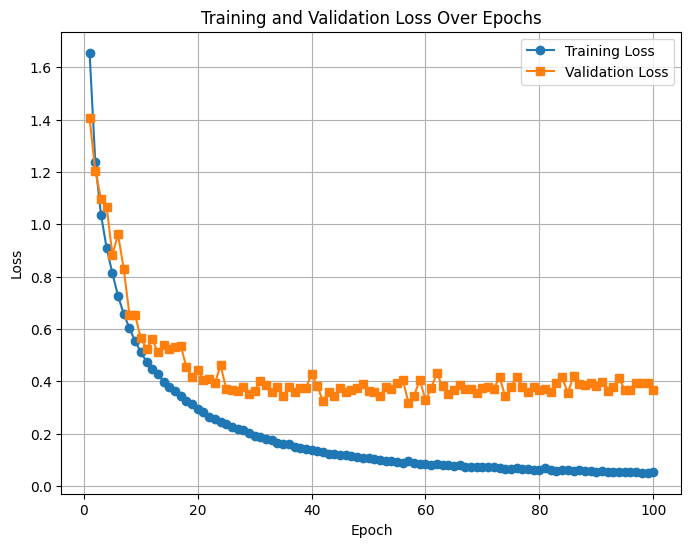

In [ ]:
# Training and Validation Loss curve
epochs_range = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(8,6))
plt.plot(epochs_range, train_loss_history, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss_history, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

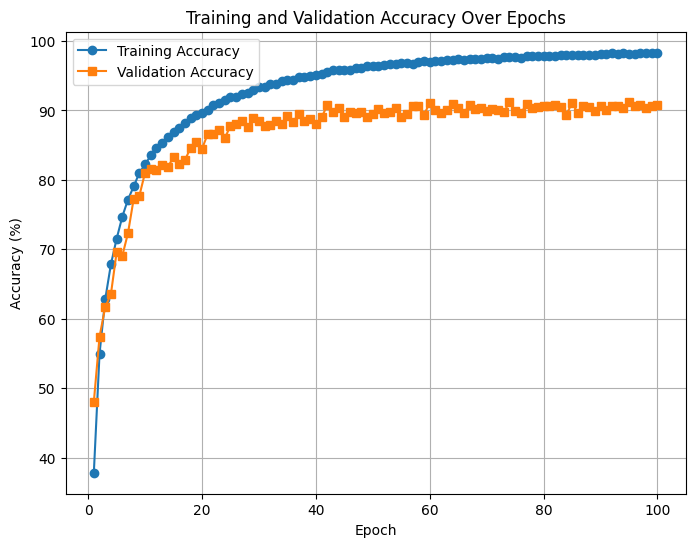

In [ ]:
# Training and Validation Accuracy curve
plt.figure(figsize=(8,6))
plt.plot(epochs_range, train_acc_history, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_curve.png')
plt.show()

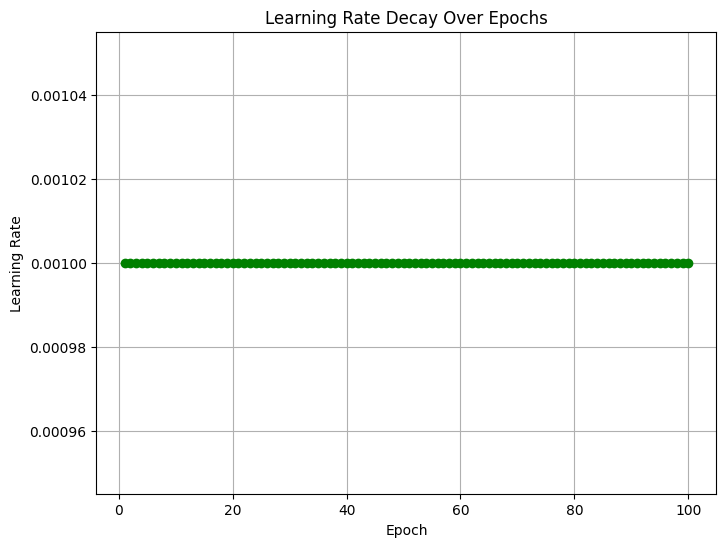

In [ ]:
# Learning Rate curve
plt.figure(figsize=(8,6))
plt.plot(epochs_range, lr_history, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay Over Epochs')
plt.grid(True)
plt.savefig('lr_curve.png')
plt.show()

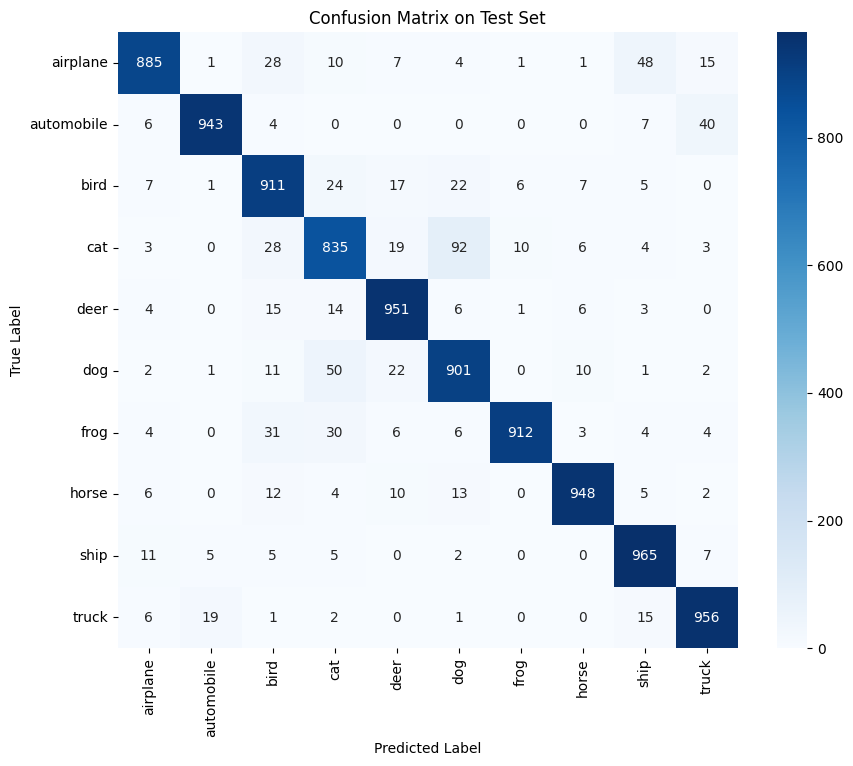

In [ ]:
# Confusion Matrix on Test Set
all_test_preds = []
all_test_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_true.extend(labels.cpu().numpy())

cm = confusion_matrix(all_test_true, all_test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig('confusion_matrix.png')
plt.show()

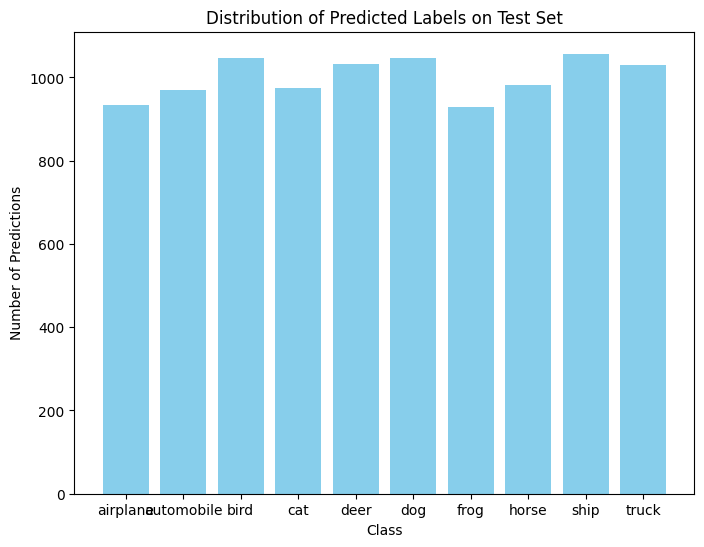

In [ ]:
# Bar Plot of Predicted Label Distribution
pred_df = pd.DataFrame({'Labels': all_test_preds})
label_counts = pred_df['Labels'].value_counts().sort_index()
plt.figure(figsize=(8,6))
plt.bar(range(len(label_counts)), label_counts, tick_label=label_names, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Labels on Test Set')
plt.savefig('predicted_distribution.png')
plt.show()

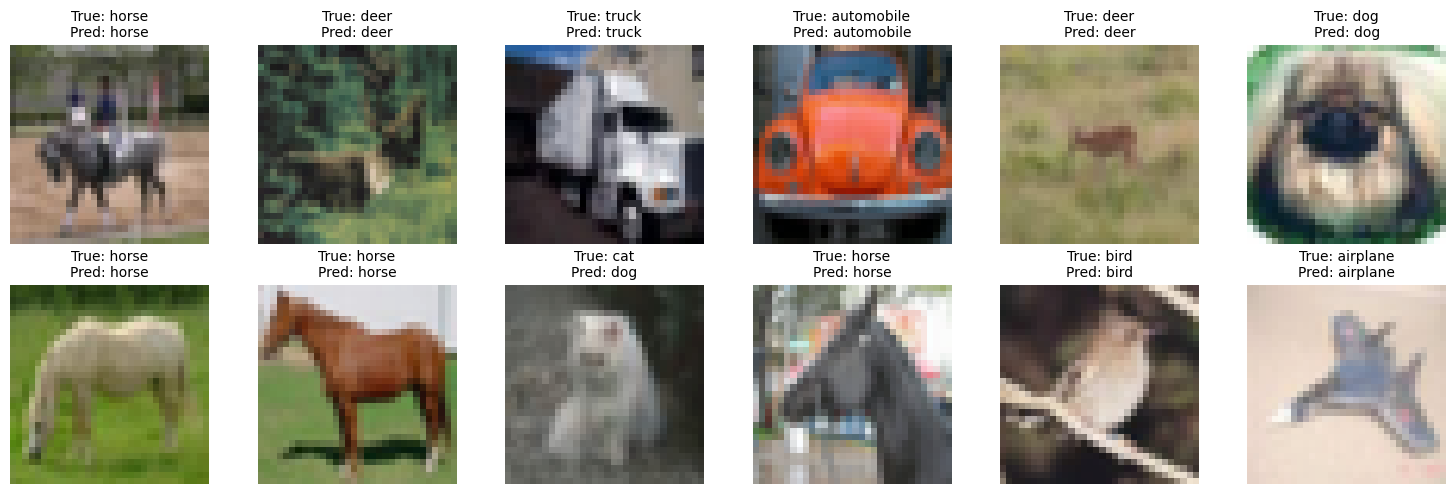

In [ ]:
# Grid of Sample Test Images with True vs Predicted Labels
def show_sample_predictions(model, dataset, num_samples=10):
    import random
    model.eval()

    # Randomly select num_samples indices
    indices = random.sample(range(len(dataset)), num_samples)
    sample_imgs = [dataset[i][0] for i in indices]
    sample_true = [dataset[i][1] for i in indices]

    inputs = torch.stack(sample_imgs).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i+1)
        img = sample_imgs[i].cpu().numpy().transpose(1,2,0)
        # Denormalize image for visualization
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.247, 0.243, 0.261])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        true_label = label_names[sample_true[i]]
        pred_label = label_names[preds[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

show_sample_predictions(model, test_dataset, num_samples=12)